In [83]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

from scipy.stats import norm
from scipy.stats import probplot

from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression

%matplotlib inline

Начнем с загрузки и небольшой предобработки данных.

In [2]:
dp = pd.read_csv('Purchase_Task.csv')

In [3]:
dp.columns

Index(['SESSION_ID', 'COOKIE_ID', 'TIMESTAMP', 'PRODUCT_ID', 'BASE_PRICE'], dtype='object')

In [4]:
dp.columns = ['session_id', 'cookie_id', 'ts', 'product_id', 'price']
dp['product_id'] = dp['product_id'].astype(int)
dp['ts'] = pd.to_datetime(dp['ts'])
dp.sort(columns=['product_id', 'ts'], inplace=True)
dp.reset_index(drop=True, inplace=True)

In [5]:
dp.head()

,session_id,cookie_id,ts,product_id,price
0,3377031228336745472,80141446963973069955883,2015-11-08 14:05:16,106710,7.0
1,8677893306950880256,70051433788546044569729,2015-11-08 15:01:45,106710,7.0
2,4516960596205848064,30071447019257273739509,2015-11-09 05:28:11,106710,7.0
3,3965600694462250496,50151446401344068180846,2015-11-11 12:41:25,106710,7.0
4,8812467277121798144,50061445846494186477919,2015-11-21 18:31:22,106710,9.0


Удалим дубликаты, сохраним данные в отдельный объект.

In [6]:
dp_ = dp[['session_id', 'cookie_id', 'ts', 'product_id', 'price']].groupby(by=['session_id', 'cookie_id', 'ts', 'product_id']).agg(['mean', 'count']).reset_index()
dp_.columns = ['session_id', 'cookie_id', 'ts', 'product_id', 'price_mean', 'purchase_count']
dp_.sort(columns=['product_id', 'ts'], inplace=True)
dp_.reset_index(inplace=True, drop=True)

Небольшая покупательная статистика. В среднем, каждый продукт покупается 4 разными клиентами.

count    11938.000000
mean         9.930139
std         41.789365
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max        730.000000
Name: product_id, dtype: float64

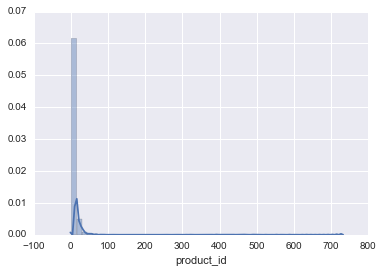

In [104]:
sns.distplot(dp_['product_id'].value_counts())
dp_['product_id'].value_counts().describe()

Так как мы имеем дело с времянным рядом, возможно в данных есть внутредневные и внутренедельные циклы. 

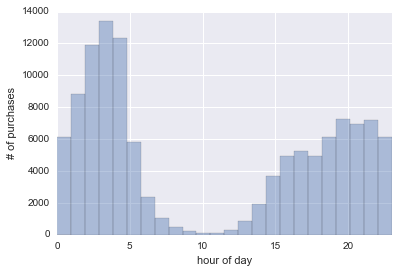

In [105]:
ax = sns.distplot(dp_['ts'].apply(lambda x: pd.to_datetime(x).hour), kde=False, bins=24)
ax.set_xlim([0, 23])
ax.set_xlabel('hour of day')
ax.set_ylabel('# of purchases')

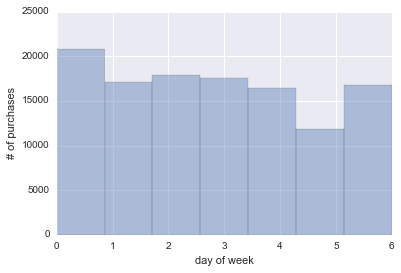

In [106]:
ax = sns.distplot(dp_['ts'].apply(lambda x: pd.to_datetime(x).dayofweek), kde=False, bins=7)
ax.set_xlabel('day of week')
ax.set_ylabel('# of purchases')

In [7]:
dv = pd.read_csv('Views_Task.csv')

In [8]:
dv.columns

Index(['SESSION_ID', 'COOKIE_ID', 'TIMESTAMP', 'PRODUCT_ID', 'Brand'], dtype='object')

In [9]:
dv.columns = ['session_id', 'cookie_id', 'ts', 'product_id', 'brand_id']
dv.sort(columns=['product_id', 'ts'], inplace=True)
dv['product_id'] = dv['product_id'].astype(int)

In [11]:
dv['session_id_'] = dv['session_id']
dv_ = dv.groupby(by=['session_id', 'cookie_id', 'ts', 'product_id', 'brand_id']).count().reset_index()
dv_.columns = ['session_id', 'cookie_id', 'ts', 'product_id', 'brand_id', 'view_count_']

In [12]:
dv_['view_count'] = 1

In [13]:
dv_.sort(columns=['product_id', 'ts'], inplace=True)
dv_.reset_index(drop=True, inplace=True)
dv_.head()

,session_id,cookie_id,ts,product_id,brand_id,view_count_,view_count
0,5577460375631325184,50041443545063027830059,2015-11-04 23:06:35,106710,2,2,1
1,3489854317609658880,30121446727827243740159,2015-11-05 19:53:14,106710,2,2,1
2,3489854317609658880,30121446727827243740159,2015-11-05 19:53:38,106710,2,2,1
3,3489854317609658880,30121446727827243740159,2015-11-05 19:53:53,106710,2,2,1
4,4411861480711565824,50051447170414067512303,2015-11-11 00:21:58,106710,2,1,1


Сгруппируем все покупок клиентов в отдельные сессии и посчитаем некоторые статистики цены и числа покупак внутри сессий.

In [21]:
sp_ = dp_[['session_id', 'product_id', 'price_mean', 'purchase_count']].groupby(by=['session_id', 'product_id']).agg([np.mean, np.std]).reset_index().fillna(value=0)
sp_.columns = ['session_id', 'product_id', 'price_session_mean', 'price_session_std', 'purchase_session_count_mean', 'purchase_session_count_std']
sp_.head()

,session_id,product_id,price_session_mean,price_session_std,purchase_session_count_mean,purchase_session_count_std
0,210702168536172,267534,7.0,0.0,2.0,0.0
1,210702168536172,590730,31.0,0.0,2.0,0.0
2,210702168536172,801359,7.0,0.0,2.0,0.0
3,213154019631725,617537,20.0,0.0,1.0,0.0
4,411423193366617,479839,18.0,0.0,1.0,0.0


Есть небольшое число сессий (88), в которых клиент купил один и тот же продукт по разной цене.

count    88.000000
mean      2.145426
std       1.641589
min       0.707107
25%       0.707107
50%       1.414214
75%       2.828427
max       7.071068
Name: price_session_std, dtype: float64

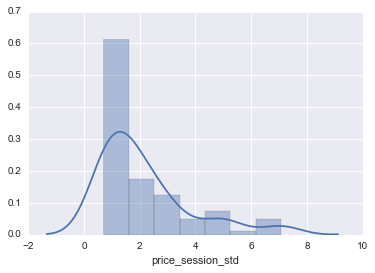

In [22]:
sns.distplot(sp_[sp_['price_session_std'] > 0]['price_session_std'])
sp_[sp_['price_session_std'] > 0]['price_session_std'].describe()

In [29]:
sp_[['dt_start', 'dt_end']] = dp_[['session_id', 'product_id', 'ts']].groupby(by=['session_id', 'product_id']).agg([np.min, np.max]).reset_index().fillna(value=0)[[('ts', 'amin'), ('ts', 'amax')]]
sp_['session_length'] = (sp_['dt_end'] - sp_['dt_start']).astype('timedelta64[s]')
sp_.head()

,session_id,product_id,price_session_mean,price_session_std,purchase_session_count_mean,purchase_session_count_std,dt_start,dt_end,session_length
0,210702168536172,267534,7.0,0.0,2.0,0.0,2015-11-01 14:15:50,2015-11-01 14:15:50,0.0
1,210702168536172,590730,31.0,0.0,2.0,0.0,2015-11-01 14:15:50,2015-11-01 14:15:50,0.0
2,210702168536172,801359,7.0,0.0,2.0,0.0,2015-11-01 14:15:50,2015-11-01 14:15:50,0.0
3,213154019631725,617537,20.0,0.0,1.0,0.0,2015-11-13 02:58:21,2015-11-13 02:58:21,0.0
4,411423193366617,479839,18.0,0.0,1.0,0.0,2015-11-10 03:29:12,2015-11-10 03:29:12,0.0


Особой зависимости между длинной сессии и такими событиями (разная цена на продукт внутри сессии) нет.

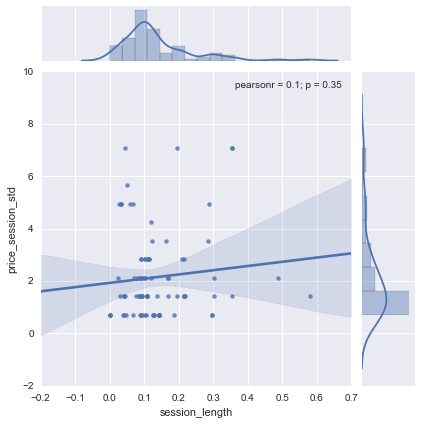

In [24]:
sns.jointplot(sp_[sp_['price_session_std'] > 0]['session_length']/3600, sp_[sp_['price_session_std'] > 0]['price_session_std'], kind='reg')

Будем считать просмотры надмножеством над покупками. Как и в покупках, 
сгруппируем просмотры в отдельные сессии, а затем дообогатим просмотры покупками.

In [25]:
sp = dv_[['session_id', 'product_id', 'ts']].groupby(by=['session_id', 'product_id']).agg([np.min, np.max]).reset_index()

In [26]:
sp.columns = ['session_id', 'product_id', 'dt_start', 'dt_end']

In [31]:
sp[['dt_start_', 'dt_end_', 'purchased_price']] = sp.merge(sp_, how='left', on=['session_id', 'product_id'])[['dt_start_y', 'dt_end_y', 'price_session_mean']]

Проверим предположение о надмножественности.

In [39]:
sp_[['session_id', 'product_id']].merge(sp[['session_id', 'product_id']], how='left', on=['session_id', 'product_id']).loc[sp_[['session_id', 'product_id']].merge(sp[['session_id', 'product_id']], how='left', on=['session_id', 'product_id']).reset_index()['session_id'
].isnull()]

,session_id,product_id


In [40]:
sp['dt_start'] = sp['dt_start'].apply(lambda x: pd.to_datetime(x))
sp['dt_end'] = sp['dt_end'].apply(lambda x: pd.to_datetime(x))
sp['dt_start_'] = sp['dt_start_'].apply(lambda x: pd.to_datetime(x))
sp['dt_end_'] = sp['dt_end_'].apply(lambda x: pd.to_datetime(x))

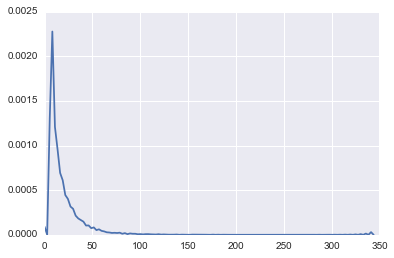

In [41]:
sns.distplot((sp['dt_end'] - sp['dt_start']).astype('timedelta64[m]'), hist=False)

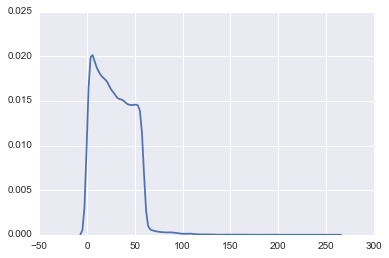

In [63]:
sns.distplot((sp[~sp['dt_end_'].isnull()].apply(lambda x: max(x['dt_end_'], x['dt_end']), axis=1) - sp[~sp['dt_end_'].isnull()].apply(lambda x: min(x['dt_start_'], x['dt_start']), axis = 1)).astype('timedelta64[m]'), hist=False)

Дообогатив просмотры покупками, длина сессии меняется странным образом и обрывается по истечении часа, возможно, автоматически завершается после совершения покупки.

Теперь соберем информацию о продуктах, сгруппировав сессии, посчитав среднюю цену, её стандартное отклонение, общее число просмотров и число просмотров до покупки.

In [51]:
pr = sp[~sp['purchased_price'].isnull()][['product_id', 'purchased_price']].fillna(value=0).groupby(by='product_id').agg([np.mean, np.std]).reset_index().fillna(value=0)
pr.columns = ['product_id', 'price_mean', 'price_std']
pr.head()

,product_id,price_mean,price_std
0,106710,7.0,0.000000
1,106862,10.0,0.000000
2,112658,24.5,2.121320
3,112664,25.0,4.582576
4,120089,99.0,0.000000


In [53]:
pr['view_count'] = pr[['product_id']].merge(sp[~sp['purchased_price'].isnull()][['product_id', 'session_id']].groupby(by='product_id').agg(['count']).reset_index(), how='left', on='product_id').ix[:, -1]

In [54]:
pr['view_count_total'] = pr[['product_id']].merge(sp[['product_id', 'session_id']].groupby(by='product_id').agg(['count']).reset_index(), how='left', on='product_id').ix[:, -1]

Для поиска выбросов в данных, для начала мы воспользуемся методом анализа гланных компонент и визуализируем полученные результаты.

In [58]:
pca = PCA(n_components=3, whiten=True)
X_r = pca.fit(scale(pr[['price_mean', 'price_std', 'view_count', 'view_count_total']])).transform(scale(pr[['price_mean', 'price_std', 'view_count', 'view_count_total']]))

In [59]:
pca.explained_variance_ratio_.sum()

0.95449852691131043

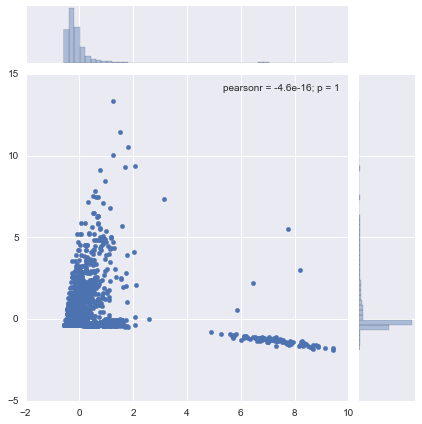

In [67]:
sns.jointplot(X_r[:, 0], X_r[:, 1])

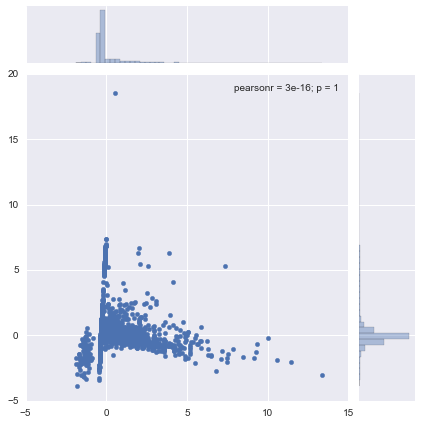

In [66]:
sns.jointplot(X_r[:, 1], X_r[:, 2])

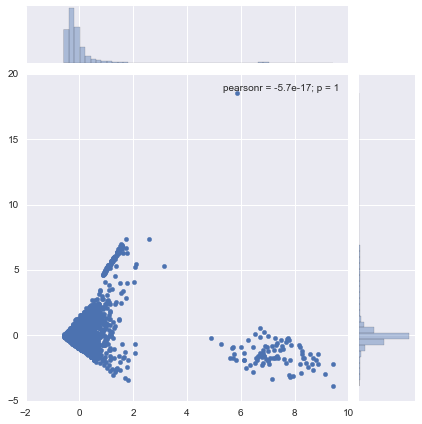

In [65]:
sns.jointplot(X_r[:, 0], X_r[:, 2])

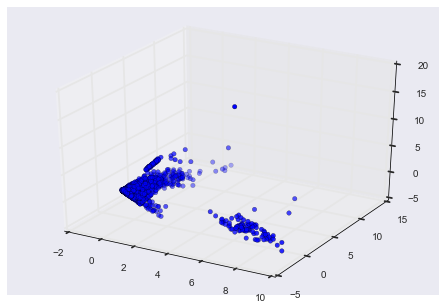

In [71]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X_r[:, 0], X_r[:, 1], X_r[:, 2])

Для идентификации выбросов, воспользуемся методом опорных векторов с радиальным ядром.
Параметр nu рассчитывается, как 0.95*число выбросов + 0.05.

In [76]:
clf = svm.OneClassSVM(gamma=0.1, kernel='rbf', nu=0.95*0.01 + 0.05)

In [77]:
clf.fit(X_r)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=0.1, kernel='rbf',
      max_iter=-1, nu=0.059500000000000004, random_state=None,
      shrinking=True, tol=0.001, verbose=False)

In [79]:
eval = clf.predict(X_r)

In [80]:
u, c = np.unique(eval, return_counts=True)
dict(zip(u, c))

{-1.0: 341, 1.0: 5378}

В итоге получаем ожидаемую картину.

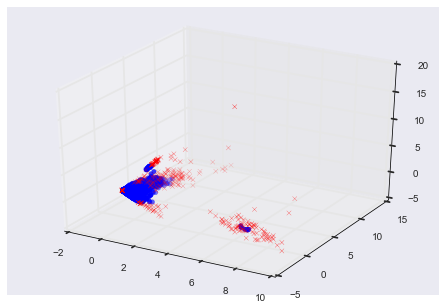

In [103]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X_r[eval==1, 0], X_r[eval==1, 1], X_r[eval==1, 2], color='b')
ax.scatter(X_r[eval==-1, 0], X_r[eval==-1, 1], X_r[eval==-1, 2], color='r', marker='x')